# LSTM-CNN Sentiment Analysis on Rotten Tomatoes Reviews

Student ID: 23C11024

Student name: Chiêm Quốc Hùng

## Introduction

This is a homework for HCMUS' Deep Learning course. The homework is based on Dr. Nguyen Tien Huy's work on the paper Multi-channel LSTM-CNN model for Vietnamesesentiment analysis ([link here](https://www.researchgate.net/publication/321259272_Multi-channel_LSTM-CNN_model_for_Vietnamese_sentiment_analysis)).

The datasets can be found in the links below:
1. Base dataset (~400mb): [rotten_tomatoes_movie_reviews.csv](https://www.kaggle.com/datasets/andrezaza/clapper-massive-rotten-tomatoes-movies-and-reviews)
2. Additional testing dataset (~200mb): [rotten_tomatoes_critic_reviews.csv](https://www.kaggle.com/datasets/stefanoleone992/rotten-tomatoes-movies-and-critic-reviews-dataset)
3. GloVe word embeddings (~1.3gb): [glove.6B.zip](https://nlp.stanford.edu/data/glove.6B.zip)

You can find the code in my [GitHub repository](https://github.com/cqhung1412/lstm_cnn_sentiment).

## Implementation

### Import dataset

In [27]:
import os
import spacy
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Conv1D, GlobalMaxPooling1D, concatenate, Dense, Dropout, BatchNormalization
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from concurrent.futures import ProcessPoolExecutor

In [4]:
# Check if TensorFlow is using GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2024-06-25 00:50:12.196025: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-25 00:50:12.224067: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-25 00:50:12.224130: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [5]:
cpu_count = os.cpu_count()
print("Num CPUs Available: ", cpu_count)

Num CPUs Available:  12


In [6]:
# Load spaCy model
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])

# Function to filter text by POS
def filter_text_by_pos(text):
    doc = nlp(text)
    filtered_text = " ".join([token.text for token in doc if token.pos_ in ['VERB', 'ADJ', 'ADV']])
    return filtered_text

# Function to apply POS filtering to a list of texts
def process_texts(texts):
    return [filter_text_by_pos(text) for text in texts]

In [7]:
# Load pre-trained GloVe embeddings
def load_glove_embeddings(glove_path, tokenizer, embedding_dim):
    embeddings_index = {}
    with open(glove_path, 'r', encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

In [8]:
data = pd.read_csv("./rotten_tomatoes_movie_reviews.csv")
data.head()

,id,reviewId,creationDate,criticName,isTopCritic,originalScore,reviewState,publicatioName,reviewText,scoreSentiment,reviewUrl
0,beavers,1145982,2003-05-23,Ivan M. Lincoln,False,3.5/4,fresh,Deseret News (Salt Lake City),Timed to be just long enough for most youngste...,POSITIVE,http://www.deseretnews.com/article/700003233/B...
1,blood_mask,1636744,2007-06-02,The Foywonder,False,1/5,rotten,Dread Central,It doesn't matter if a movie costs 300 million...,NEGATIVE,http://www.dreadcentral.com/index.php?name=Rev...
2,city_hunter_shinjuku_private_eyes,2590987,2019-05-28,Reuben Baron,False,NaN,fresh,CBR,The choreography is so precise and lifelike at...,POSITIVE,https://www.cbr.com/city-hunter-shinjuku-priva...
3,city_hunter_shinjuku_private_eyes,2558908,2019-02-14,Matt Schley,False,2.5/5,rotten,Japan Times,The film's out-of-touch attempts at humor may ...,NEGATIVE,https://www.japantimes.co.jp/culture/2019/02/0...
4,dangerous_men_2015,2504681,2018-08-29,Pat Padua,False,NaN,fresh,DCist,Its clumsy determination is endearing and some...,POSITIVE,http://dcist.com/2015/11/out_of_frame_dangerou...


### Data cleaning

In [9]:
# Drop missing reviewText rows
data = data.dropna(subset=['reviewText'])

# Only use reviewState (result) and reviewText columns
data = data[['reviewState', 'reviewText']]

# Encode sentiment
data['sentiment'] = data['reviewState'].apply(lambda x: 1 if x == 'fresh' else 0)

data.head()

,reviewState,reviewText,sentiment
0,fresh,Timed to be just long enough for most youngste...,1
1,rotten,It doesn't matter if a movie costs 300 million...,0
2,fresh,The choreography is so precise and lifelike at...,1
3,rotten,The film's out-of-touch attempts at humor may ...,0
4,fresh,Its clumsy determination is endearing and some...,1


### Training and testing data preparation

In [10]:
# Extract texts and labels
texts = data['reviewText'].values
labels = data['sentiment'].values

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=69)

# Apply POS filtering to the training set only
# Split the data into chunks for parallel processing
num_chunks = cpu_count
chunks = np.array_split(x_train, num_chunks)

# Process the chunks in parallel
with ProcessPoolExecutor(max_workers=num_chunks) as executor:
    x_train_filtered_chunks = list(executor.map(process_texts, chunks))

# Combine the chunks back into a single list
x_train_filtered = [item for sublist in x_train_filtered_chunks for item in sublist]

In [39]:
# Parameters
max_features = 1000
max_len = 100
embedding_dim = 100

# Text tokenizing
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train_filtered)
x_train_sequences = tokenizer.texts_to_sequences(x_train_filtered)
# tokenizer.fit_on_texts(x_train)
# x_train_sequences = tokenizer.texts_to_sequences(x_train)
x_test_sequences = tokenizer.texts_to_sequences(x_test)

# Pad sequences
x_train_padded = pad_sequences(x_train_sequences, maxlen=max_len)
x_test_padded = pad_sequences(x_test_sequences, maxlen=max_len)

### Model layers

In [40]:
glove_path = './glove.6B/glove.6B.100d.txt'
embedding_matrix = load_glove_embeddings(glove_path, tokenizer, embedding_dim)

# Embedding layer with pre-trained weights
embedding_layer = Embedding(len(tokenizer.word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            trainable=False)

In [49]:
# LSTM branch (with Batch Normalization and Dropout)
lstm_input = Input(shape=(max_len,))
embedded_sequences_lstm = embedding_layer(lstm_input)
lstm_out = LSTM(128, return_sequences=True)(embedded_sequences_lstm)
lstm_out = BatchNormalization()(lstm_out) # Batch Normalization helps to normalize activations and speed up convergence
lstm_out = Dropout(0.5)(lstm_out) # Dropout = 0.5 helps to prevent overfitting
lstm_out = LSTM(64, return_sequences=True)(lstm_out)
lstm_out = BatchNormalization()(lstm_out)
lstm_out = Dropout(0.5)(lstm_out)
lstm_out = LSTM(32)(lstm_out)
lstm_out = BatchNormalization()(lstm_out)
lstm_out = Dropout(0.5)(lstm_out)

# CNN layer branch (with Batch Normalization and Dropout)
cnn_input = Input(shape=(max_len,))
embedded_sequences_cnn = embedding_layer(cnn_input)
cnn_out = Conv1D(128, 5, activation='relu')(embedded_sequences_cnn)
cnn_out = BatchNormalization()(cnn_out)
cnn_out = Dropout(0.5)(cnn_out)
cnn_out = Conv1D(64, 5, activation='relu')(cnn_out)
cnn_out = BatchNormalization()(cnn_out)
cnn_out = Dropout(0.5)(cnn_out)
cnn_out = Conv1D(32, 5, activation='relu')(cnn_out)
cnn_out = BatchNormalization()(cnn_out)
cnn_out = Dropout(0.5)(cnn_out)
cnn_out = GlobalMaxPooling1D()(cnn_out)

# Concatenate LSTM and CNN outputs
merged = concatenate([lstm_out, cnn_out])
merged = Dense(32, activation='relu')(merged)
merged = BatchNormalization()(merged)
merged = Dropout(0.5)(merged)
pred = Dense(1, activation='sigmoid')(merged)

# Build model
model = Model(inputs=[lstm_input, cnn_input], outputs=pred)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_21      │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_22      │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 100, 100)  │  5,221,400 │ input_layer_21[0… │
│ (Embedding)         │                   │            │ input_layer_22[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_23 (Conv1D)  │ (None, 96, 128)   │     64,128 │ embedding_1[9][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_37 (LSTM)      │ (None, 100, 128)  │    117,248 │ embedding_1[8][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 96, 128)   │        512 │ conv1d_23[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 128)  │        512 │ lstm_37[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_66          │ (None, 96, 128)   │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_63          │ (None, 100, 128)  │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_24 (Conv1D)  │ (None, 92, 64)    │     41,024 │ dropout_66[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_38 (LSTM)      │ (None, 100, 64)   │     49,408 │ dropout_63[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 92, 64)    │        256 │ conv1d_24[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 64)   │        256 │ lstm_38[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_67          │ (None, 92, 64)    │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_64          │ (None, 100, 64)   │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_25 (Conv1D)  │ (None, 88, 32)    │     10,272 │ dropout_67[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_39 (LSTM)      │ (None, 32)        │     12,416 │ dropout_64[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 88, 32)    │        128 │ conv1d_25[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ lstm_39[0][0]   

 Total params: 5,519,929 (21.06 MB)

 Trainable params: 297,569 (1.14 MB)

 Non-trainable params: 5,222,360 (19.92 MB)

### Train and evaluate model

In [50]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) # stop training when the validation loss stops improving to prevent overfitting
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001) # reduce the learning rate when the validation loss plateaus, allowing finer convergence

In [51]:
# Train model
history = model.fit([x_train_padded, x_train_padded], y_train, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5
27515/27515 ━━━━━━━━━━━━━━━━━━━━ 1463s 53ms/step - accuracy: 0.6912 - loss: 0.6374 - val_accuracy: 0.7261 - val_loss: 0.5454
Epoch 2/5
27515/27515 ━━━━━━━━━━━━━━━━━━━━ 1449s 53ms/step - accuracy: 0.7261 - loss: 0.5406 - val_accuracy: 0.7444 - val_loss: 0.5263
Epoch 3/5
27515/27515 ━━━━━━━━━━━━━━━━━━━━ 1438s 52ms/step - accuracy: 0.7338 - loss: 0.5299 - val_accuracy: 0.7472 - val_loss: 0.5184
Epoch 4/5
27515/27515 ━━━━━━━━━━━━━━━━━━━━ 1451s 53ms/step - accuracy: 0.7359 - loss: 0.5244 - val_accuracy: 0.7425 - val_loss: 0.5132
Epoch 5/5
27515/27515 ━━━━━━━━━━━━━━━━━━━━ 1452s 53ms/step - accuracy: 0.7384 - loss: 0.5215 - val_accuracy: 0.7342 - val_loss: 0.5172


In [52]:
# Evaluate model
score = model.evaluate([x_test_padded, x_test_padded], y_test)
print(f"Test accuracy: {score[1]}")

8599/8599 ━━━━━━━━━━━━━━━━━━━━ 138s 16ms/step - accuracy: 0.7329 - loss: 0.5285
Test accuracy: 0.7337396740913391


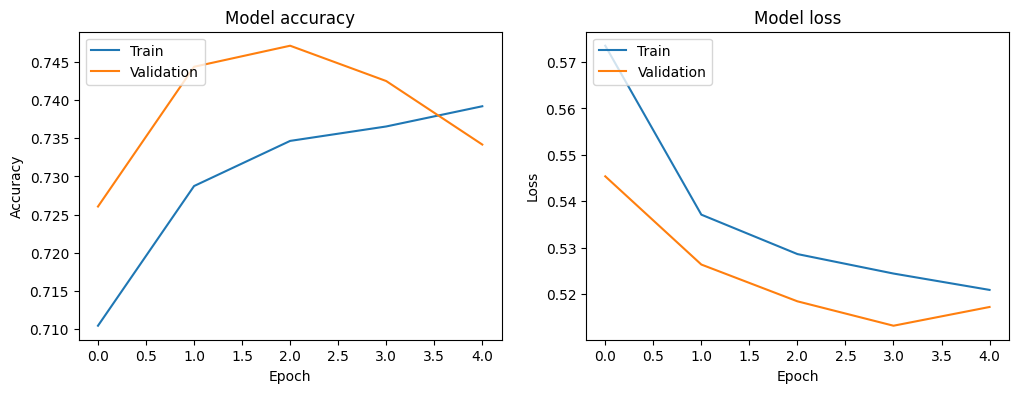

In [53]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

### Additional testing

In [54]:
data = pd.read_csv("./rotten_tomatoes_critic_reviews.csv")
data.head()

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
0,m/0814255,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology...
1,m/0814255,Louise Keller,False,Urban Cinefile,Fresh,NaN,2010-02-06,"Uma Thurman as Medusa, the gorgon with a coiff..."
2,m/0814255,NaN,False,FILMINK (Australia),Fresh,NaN,2010-02-09,With a top-notch cast and dazzling special eff...
3,m/0814255,Ben McEachen,False,Sunday Mail (Australia),Fresh,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...
4,m/0814255,Ethan Alter,True,Hollywood Reporter,Rotten,NaN,2010-02-10,What's really lacking in The Lightning Thief i...


In [55]:
# Drop missing review_content rows
data = data.dropna(subset=['review_content'])

# Only use review_type (result) and review_content columns
data = data[['review_type', 'review_content']]

# Encode sentiment
data['sentiment'] = data['review_type'].apply(lambda x: 1 if x == 'Fresh' else 0)

data.head()

,review_type,review_content,sentiment
0,Fresh,A fantasy adventure that fuses Greek mythology...,1
1,Fresh,"Uma Thurman as Medusa, the gorgon with a coiff...",1
2,Fresh,With a top-notch cast and dazzling special eff...,1
3,Fresh,Whether audiences will get behind The Lightnin...,1
4,Rotten,What's really lacking in The Lightning Thief i...,0


In [56]:
# Extract texts and labels
texts = data['review_content'].values
labels = data['sentiment'].values

# Text tokenizing
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

# Pad sequences
data = pad_sequences(sequences, maxlen=max_len)

In [57]:
# Evaluate model
score = model.evaluate([data, data], labels)
print(f"Test accuracy: {score[1]}")

33257/33257 ━━━━━━━━━━━━━━━━━━━━ 538s 16ms/step - accuracy: 0.6134 - loss: 0.7961
Test accuracy: 0.621994137763977


In [58]:
model.save('./models/rotten_tomatoes_sentiment_model.keras', overwrite=True)
model.save_weights("./models/rotten_tomatoes_sentiment_model.weights.h5", overwrite=True)

## Results

| # | Model | Base Testing Accuracy | Base Testing Loss | Additional Testing Accuracy | Additional Testing Loss |
| --- | --- | --- | --- | --- | --- |
| 1 | Initial model (128/64) | _ | _ | 0.5530 | 1.0205 |
| 2 | Bigger model (256/128) with Batch Normalization and Dropout + Filtered content for training + 5 epochs | _ | _ | 0.5806 | 0.7253 |
| 3 | Node-reduced model (128/64) + Filtered content + GloVe 6B 100d word embedding + 10 epochs | 0.7412 | 0.5101 | 0.5973 | 0.8537 |
| 4 | Model (128/64) + Non-filtered content + GloVe 6B 300d word embedding + 10 epochs | **0.7987** | 0.4815 | 0.5765 | 1.3394 |
| 5 | Bigger model (256/128) + Filtered content + GloVe 6B 300d word embedding + 5 epochs | 0.7422 | 0.5109 | *0.6048* | 0.8003 |
| 6 | Extra-layer smaller model (128/64/32) + Corrected usage of binary_crossentropy loss function and sigmoid activation + GloVe 6B 100d word embedding + 5 epochs | 0.7329  | 0.5285 | **0.6134** | 0.7961 |

## Conclusion

In the 3rd training iteration, the model has achieved a 59.73% accuracy on the additional testing dataset, a 74.12% accuracy on the base testing dataset. The model has been trained with a reduced number of nodes (64/128) and filtered content. The model has also been trained with GloVe 6B 100d word embeddings and 10 epochs. The model has shown a significant improvement in accuracy compared to the initial model (55.30% accuracy on the additional testing dataset).

However, in the 4th training iteration, the model has achieved a 57.65% accuracy on the additional testing dataset, a 79.87% accuracy on the base testing dataset. The model has been trained with the same number of nodes (64/128) and non-filtered content. The model has also been trained with GloVe 6B 300d word embeddings and 10 epochs. The model has shown a decrease in accuracy compared to the 3rd training iteration while having ***a higher overfitting issue*** (increased 5.75% accuracy on base testing dataset).

Finally, in the 6th training iteration, the model has achieved a 61.34% accuracy on the additional testing dataset, a 73.29% accuracy on the base testing dataset. The model has been trained with an extra layer (64/128/32) and corrected usage of binary_crossentropy loss function and sigmoid activation (previously, the models used binary_crossentropy and softmax). The model has also been trained with GloVe 6B 100d word embeddings and 5 epochs. The model has shown a significant improvement in accuracy compared to the 4th and 5th training iteration.

The model can be further improved by:
- Adding more filters to the initial review content (remove special characters, stopwords, etc.).
- Using more data for training (k-fold cross validation).

## References

- [Multi-channel LSTM-CNN model for Vietnamesesentiment analysis](https://www.researchgate.net/publication/321259272_Multi-channel_LSTM-CNN_model_for_Vietnamese_sentiment_analysis)

Some interesting references for further development:
- [Kaggle Sentiment Analysis: Rotten Tomato Movie Reviews](https://www.kaggle.com/code/oragula/sentiment-analysis-rotten-tomato-movie-reviews)